In [1]:
%run ./resources/library.py

In [2]:
# Run this cell if not using JupyterLab
style_notebook()

# Notebook 2 - Advanced: Analyzing the John Snow Cholera Outbreak Using OpenStreetMaps and Networkx - Part 2

## Learning Objectives

By the end of this notebook, you should be able to:

1. Recall how to load and save `osmnx` street network graphs 
2. Recall how to load data from CSV and pickle files using `pandas`
3. Describe how the three distances, d1, d2 and d3, are computed using `osmnx`
4. Describe how a nested loop works to calculate the route distance between 2 nodes (pumps and deaths)
5. Identify how this algorithm pattern can be used in solving other public health problems.

## Summary of steps

We will carry out the following <font color=red>steps</font>:

<font color=red>Step 1</font> - Read the street network graph, `G`, of Soho district using OSMnx using a set of coordinates in the middle of Soho district. **(We saved this graph in Notebook 2 and we will read it from the graphml file `soho.graphml`.)**  
   
   
<font color=red>Step 2</font> - Load the original data sets from Notebook 1, Basic, (pumps and deaths) into `pumps_df` and `deaths_df`.


<font color=red>Step 3</font> - To represent coordinates from the pumps and deaths from the Notebook 1 in OSMnx graph format, we have to find the nearest OSMnx nodes to those points. We will add new columns to the pumps and deaths dataframes to accomodate new information coming from OSMnx. We will also store the short distances between original points to the nearest OSMnx points and store it in the respective dataframes.

<font color=red>Step 4</font> -  To calculate mean distances from death coordinates to pump coordinates we will create a nested loop through records of both dataframes, `pumps_df` and `deaths_df`, for pairwise distance calculations between each pump and death coordinates. We will add the short distances from #1 to the pump point to death point distance and store this in a new dataframe called `routes_df`.

<font color=red>Step 5</font> - We will then create the map representation pump-to-death-points mean distances using `folium` and superimpose this on the markers generated in Notebook 1.

In [3]:
# import osmnx package, use "ox" as alias
import osmnx as ox

# set some configuration parameters for osmnx
# print version of package
ox.config(log_file=True, log_console=True, use_cache=True)

ox.__version__

'0.15.0'

Let's read our street network graph from file using the dot function, <font color=red>`load_graphml()`</font>.

In [4]:
G = ox.load_graphml(filepath='outputs/soho.graphml')

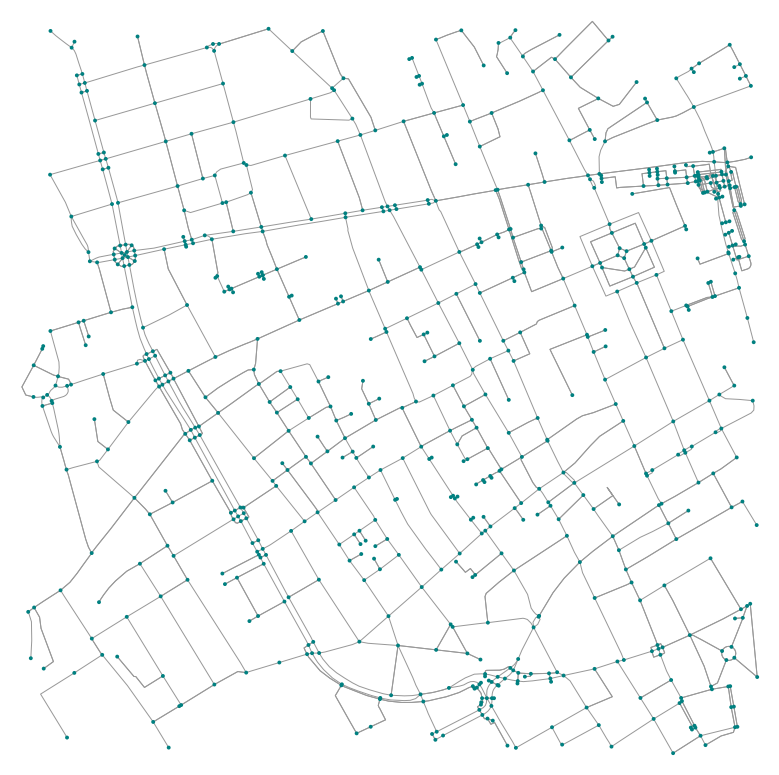

In [5]:
fig, ax = ox.plot_graph(G, figsize=(14,14), \
                        bgcolor='white', \
                        node_color='teal')

## Step 2. Load pumps and deaths data sets

Let's read the data set from a pickle file using the dot function <font color=red>`read_pickle()`</font>. 

In [6]:
import pandas as pd

# Read CSV with cholera deaths.
deaths_df = pd.read_pickle('outputs/mean_center_df.pickle')

# display dataframe records
deaths_df

,FID,DEATHS,LON,LAT,product_LAT,product_LON
0,0,3,-0.137930,51.513418,154.540254,-0.413790
1,1,2,-0.137883,51.513361,103.026722,-0.275766
2,2,1,-0.137853,51.513317,51.513317,-0.137853
3,3,1,-0.137812,51.513262,51.513262,-0.137812
4,4,4,-0.137767,51.513204,206.052816,-0.551068
...,...,...,...,...,...,...
245,245,3,-0.137108,51.514526,154.543578,-0.411324
246,246,2,-0.137065,51.514706,103.029412,-0.274130
247,247,1,-0.138474,51.512311,51.512311,-0.138474
248,248,1,-0.138123,51.511998,51.511998,-0.138123


In [7]:
import geopandas

gdf = geopandas.GeoDataFrame(
    deaths_df, geometry=geopandas.points_from_xy(deaths_df.LON, deaths_df.LAT),\
    crs='epsg:4236')

This dataframe has two additional columns, `product_LAT` and `product_LON` resulting from computing for the mean center in Notebook 2.

Next, let's read the pickle file for pumps.

In [8]:
# Read CSV with pumps.
pumps_df = pd.read_pickle('outputs/pumps_df.pickle')

pumps_df

,FID,LON,LAT,Street,PNODE
0,250,-0.136668,51.513341,Broadwick Street,25473293
1,251,-0.139586,51.513876,Kingly Street,21665926
2,252,-0.139671,51.514906,Ramillies Place,4684520654
3,253,-0.131630,51.512354,Dean Street,107807
4,254,-0.133594,51.512139,Rupert Street,348875443
5,255,-0.135919,51.511542,Bridle Lane,25473300
6,256,-0.133962,51.510019,Regent Street,1663004187
7,257,-0.138199,51.511295,Warwick Street,25257692


## Step 3: Set up `pumps_df` and `deaths_df` dataframes to store additional `osmnx` information

### Set up `pumps_df` dataframe for analysis

Let's create five new columns for `pumps_df`:
1. Two (2),<font color=red>`pumps_df['GLON']`</font> and <font color=red>`pumps_df['GLAT']`</font>, to store coordinates from the OSMnx graph nodes that correspond to original pump coordinates.
2. <font color=red>`pumps_df['DISTANCE']`</font> to store distance between original pump coordinates and OSMnx graph coordinates
3. <font color=red>`pumps_df['NODE']`</font> to store the node ID of an OSMnx graph node coordinate 
4. <font color=red>`pumps_df['MEAN_DISTANCE']`</font> to store the mean distance values between pump and death graph coordinates (to be computed later).

We also store default values for these columns as below.

In [9]:
pumps_df['GLON'] = 0.00
pumps_df['GLAT'] = 0.00
pumps_df['NEAREST-NODE-DISTANCE'] = 0.00
pumps_df['NODE'] = 0
pumps_df['NODE'].astype(int)
pumps_df['DEATHS-MEAN-DISTANCE'] = 0.00

pumps_df

,FID,LON,LAT,Street,PNODE,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE,DEATHS-MEAN-DISTANCE
0,250,-0.136668,51.513341,Broadwick Street,25473293,0.0,0.0,0.0,0,0.0
1,251,-0.139586,51.513876,Kingly Street,21665926,0.0,0.0,0.0,0,0.0
2,252,-0.139671,51.514906,Ramillies Place,4684520654,0.0,0.0,0.0,0,0.0
3,253,-0.131630,51.512354,Dean Street,107807,0.0,0.0,0.0,0,0.0
4,254,-0.133594,51.512139,Rupert Street,348875443,0.0,0.0,0.0,0,0.0
5,255,-0.135919,51.511542,Bridle Lane,25473300,0.0,0.0,0.0,0,0.0
6,256,-0.133962,51.510019,Regent Street,1663004187,0.0,0.0,0.0,0,0.0
7,257,-0.138199,51.511295,Warwick Street,25257692,0.0,0.0,0.0,0,0.0


You can verify the data types for `pumps_df` columns with <font color=red>`dtypes`</font> dataframe attribute like so.

In [10]:
pumps_df.dtypes

FID                        int64
LON                      float64
LAT                      float64
Street                    object
PNODE                     object
GLON                     float64
GLAT                     float64
NEAREST-NODE-DISTANCE    float64
NODE                       int64
DEATHS-MEAN-DISTANCE     float64
dtype: object

We use a cell magic <font color=red>`%%time`</font> to time the execution of each loop.

In [11]:
import osmnx as ox

In [12]:
for row in pumps_df.iterrows():
    pnode, pdistance = \
       ox.get_nearest_node(G, (row[1]['LAT'],row[1]['LON']), return_dist=True)
    pumps_df.at[row[0], 'GLON'] = G.nodes[pnode]['x']
    pumps_df.at[row[0], 'GLAT'] = G.nodes[pnode]['y']
    pumps_df.at[row[0], 'NEAREST-NODE-DISTANCE'] = pdistance # distance is provided in meters
    pumps_df.at[row[0], 'NODE'] = pnode

The code above obtains the distance between pump coordinates and OSMnx node coordinates using the <font color=red>`ox.get_nearest_node()`</font> as shown in the diagram below.

**Figure 1.** In computing for node-to-node distance using `osmnx`, we have to account for the small distance between the actual lat/lon point representing either pumps or death locations and `osmnx` nodes. This diagram shows the approach for calculating this short distance using `osmnx` dot function called `ox.get_nearest_node()` - EQUATION 1 below.

![](images/osmnx1.png)

To quickly obtain the mean of all values from the `NEAREST-NODE-DISTANCE` column, we use the `pandas` dot function, <font color=red>`mean()`</font>.

In [13]:
pumps_df['NEAREST-NODE-DISTANCE'].mean()

12.010458167092478

You can make the print out more human-friendly by adding "meters".

In [14]:
print(pumps_df['NEAREST-NODE-DISTANCE'].mean(), "meters")

12.010458167092478 meters


> What does this value mean?

In [15]:
pumps_df['NEAREST-NODE-DISTANCE'].max()

20.870820028733156

In [16]:
pumps_df['NEAREST-NODE-DISTANCE'].min()

2.1670330346086772

In [17]:
pumps_df

,FID,LON,LAT,Street,PNODE,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE,DEATHS-MEAN-DISTANCE
0,250,-0.136668,51.513341,Broadwick Street,25473293,-0.136533,51.513391,10.882904,25473293,0.0
1,251,-0.139586,51.513876,Kingly Street,21665926,-0.139462,51.513861,8.746021,21665926,0.0
2,252,-0.139671,51.514906,Ramillies Place,4684520654,-0.139904,51.514855,17.076661,4684520654,0.0
3,253,-0.131630,51.512354,Dean Street,107807,-0.131466,51.512196,20.870820,107807,0.0
4,254,-0.133594,51.512139,Rupert Street,348875443,-0.133606,51.512189,5.593686,348875443,0.0
5,255,-0.135919,51.511542,Bridle Lane,25473300,-0.135762,51.511404,18.794758,25473300,0.0
6,256,-0.133962,51.510019,Regent Street,1663004187,-0.133994,51.510125,11.951782,1663004187,0.0
7,257,-0.138199,51.511295,Warwick Street,25257692,-0.138178,51.511281,2.167033,25257692,0.0


Text(0.5, 0, 'Pumps')

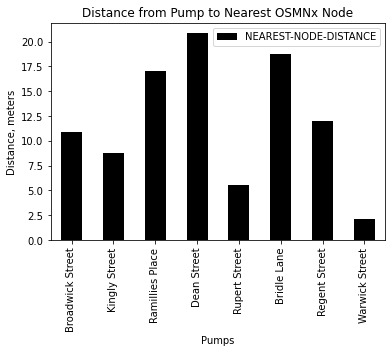

In [18]:
ax = pumps_df.plot.bar(y='NEAREST-NODE-DISTANCE', x='Street', color='k')
ax.set_title('Distance from Pump to Nearest OSMNx Node')
ax.set_ylabel('Distance, meters')
ax.set_xlabel('Pumps')

The `NEAREST-NODE-DISTANCE` column in `pumps_df` represent `d1` in Figure 1.

### Set up `deaths_df` dataframe for analysis

In [19]:
deaths_df = deaths_df[['DEATHS', 'LON', 'LAT']]
deaths_df['DEATHS'].astype(int)
deaths_df['GLON'] = 0.00
deaths_df['GLAT'] = 0.00
deaths_df['NEAREST-NODE-DISTANCE'] = 0.00
deaths_df['NODE'] = 0
deaths_df['NODE'].astype(int)
deaths_df.dtypes

DEATHS                     int64
LON                      float64
LAT                      float64
GLON                     float64
GLAT                     float64
NEAREST-NODE-DISTANCE    float64
NODE                       int64
dtype: object

In [20]:
deaths_df.tail()

,DEATHS,LON,LAT,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE
245,3,-0.137108,51.514526,0.0,0.0,0.0,0
246,2,-0.137065,51.514706,0.0,0.0,0.0,0
247,1,-0.138474,51.512311,0.0,0.0,0.0,0
248,1,-0.138123,51.511998,0.0,0.0,0.0,0
249,1,-0.137762,51.511856,0.0,0.0,0.0,0


In [21]:
%%time
for row in deaths_df.iterrows():
    dnode, ddistance = ox.get_nearest_node(G, \
                    (row[1]['LAT'],row[1]['LON']), \
                    return_dist=True)
    deaths_df.at[row[0], 'GLON'] = G.nodes[dnode]['x']
    deaths_df.at[row[0], 'GLAT'] = G.nodes[dnode]['y']
    deaths_df.at[row[0], 'NEAREST-NODE-DISTANCE'] = ddistance
    deaths_df.at[row[0], 'NODE'] = dnode

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.01 s


In [22]:
deaths_df['NEAREST-NODE-DISTANCE'].mean()

15.583112889094387

In [23]:
deaths_df.head()

,DEATHS,LON,LAT,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE
0,3,-0.137930,51.513418,-0.137948,51.513408,1.694870,25501340
1,2,-0.137883,51.513361,-0.137948,51.513408,6.887505,25501340
2,1,-0.137853,51.513317,-0.137835,51.513236,9.138483,701600719
3,1,-0.137812,51.513262,-0.137835,51.513236,3.332689,701600719
4,4,-0.137767,51.513204,-0.137835,51.513236,5.861695,701600719


In [24]:
deaths_df.dtypes

DEATHS                     int64
LON                      float64
LAT                      float64
GLON                     float64
GLAT                     float64
NEAREST-NODE-DISTANCE    float64
NODE                       int64
dtype: object

In [25]:
deaths_df['NEAREST-NODE-DISTANCE'].mean()

15.583112889094387

In [26]:
deaths_df['NEAREST-NODE-DISTANCE'].min()

0.5721981045018782

In [27]:
deaths_df['NEAREST-NODE-DISTANCE'].max()

42.224050058475044

Text(0.5, 0, 'Distance from Mortality Locations to \nNearest OSMNx Node, meters')

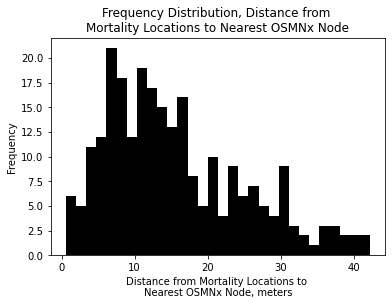

In [28]:
ax = deaths_df['NEAREST-NODE-DISTANCE'].plot.hist(bins=30, color='k')
ax.set_title('Frequency Distribution, Distance from \nMortality Locations to Nearest OSMNx Node')
ax.set_ylabel('Frequency')
ax.set_xlabel('Distance from Mortality Locations to \nNearest OSMNx Node, meters')

## Step 4: Pairwise calculation of distance between `deaths_df` and `pumps_df` coordinates using a nested loop

### Explanation of algorithm for pair-wise calculations

This code snippet below obtains the total distance, `d1 + d2 + d3`.
```
    d1 = row_pump['NEAREST-NODE-DISTANCE']
    d2 = row_death['NEAREST-NODE-DISTANCE']
    d3 = nx.shortest_path_length(G, death_node, pump_node, weight='length')
    total_distance = d1 + d2 + d3

    distance = \
          nx.shortest_path_length(G, death_node, pump_node, weight='length') + \ 
          row_death[1]['DISTANCE'] + row_pump[1]['DISTANCE']
```
By this time we have obtained three sets of distance values, `d1`, `d2` and `d3` (see Figure 2 below):
1. <font color=red>`d1`</font> = distance in meters between coordinates of an actual pump and an OSMnx node from graph, `G` from `row_death[1]['DISTANCE']`
2. <font color=red>`d2`</font> = distance in meters between coordinates of a death location and an OSMnx node from graph, `G` from `row_pump[1]['DISTANCE']`
3. <font color=red>`d3`</font> = distance in meters between coordinates of two OSMnx nodes (pump and death location, or `PNODE` and `DNODE`, respectively in the `routes_df` dataframe) from <font color=red>`nx.shortest_path_length(G, dnode, pnode, weight='length')`</font>

**Figure 2.** Diagram describing the measurement of node to node distance.

![](images/osmnx2.png)

In [29]:
import networkx as nx
# create empty list, lst, to store node and distance data 
#    from pairwise matching
new_list = []

# carry out pairwise calculations
# outer loop
for index, row_pump in pumps_df.iterrows():
    # inner loop
    for index, row_death in deaths_df.iterrows():
        death_node = row_death['NODE']
        pump_node = row_pump['NODE']
        d1 = row_pump['NEAREST-NODE-DISTANCE']
        d2 = row_death['NEAREST-NODE-DISTANCE']
        d3 = nx.shortest_path_length(G, death_node, pump_node, weight='length') 
        distance = d1 + d2 + d3
        new_list.append([int(death_node), int(pump_node), distance])     

Let's create a new dataframe, `routes_df` from the list.

In [30]:
columns = ['DNODE','PNODE','PD_DISTANCE']
routes_df = pd.DataFrame(new_list, columns=columns)

In [31]:
routes_df

,DNODE,PNODE,PD_DISTANCE
0,25501340,25473293,149.067774
1,25501340,25473293,154.260409
2,701600719,25473293,135.818387
3,701600719,25473293,130.012593
4,701600719,25473293,132.541599
...,...,...,...
1995,21666019,25257692,728.396815
1996,9521025,25257692,663.740961
1997,108070,25257692,244.430113
1998,108070,25257692,228.501246


In [32]:
routes_df['PD_DISTANCE'].min()

21.48201559582551

In [33]:
routes_df['PD_DISTANCE'].max()

1134.6384698350962

Text(0.5, 0, 'Total Distance, meters')

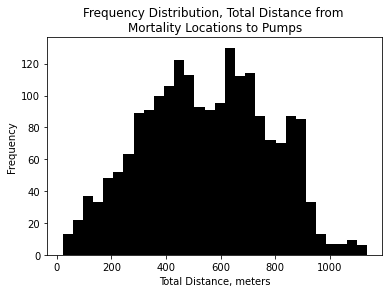

In [34]:
ax = routes_df['PD_DISTANCE'].plot.hist(bins=30, color='k')
ax.set_title('Frequency Distribution, Total Distance from \nMortality Locations to Pumps')
ax.set_ylabel('Frequency')
ax.set_xlabel('Total Distance, meters')

### Walkability Assumption, 400 meters

How far would Soho district residents walk to get water?

Using the last histogram above, let's assume that the residents of Soho district would be willing to walk 400 meters to fetch water from each pump by setting a filter of 400 meters or less as "walkable". Let's create a new dataframe, `routes400m_df`, containing node-to-node distance values <= 400 meters.

In [35]:
routes400m_df = routes_df[routes_df['PD_DISTANCE']<=400]

Let's inspect that filtered dataframe, `routes400m_df`. 

After filtering, how many rows did we end up with? What's the shortest / longest walk in this new dataset of pump-death inter-node distance?

In [36]:
routes400m_df

,DNODE,PNODE,PD_DISTANCE
0,25501340,25473293,149.067774
1,25501340,25473293,154.260409
2,701600719,25473293,135.818387
3,701600719,25473293,130.012593
4,701600719,25473293,132.541599
...,...,...,...
1859,25473408,25257692,389.268809
1860,25473408,25257692,385.845210
1997,108070,25257692,244.430113
1998,108070,25257692,228.501246


In [37]:
routes400m_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DNODE        571 non-null    int64  
 1   PNODE        571 non-null    int64  
 2   PD_DISTANCE  571 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 17.8 KB


Text(0.5, 0, 'Distance from mortality locations to pumps, meters')

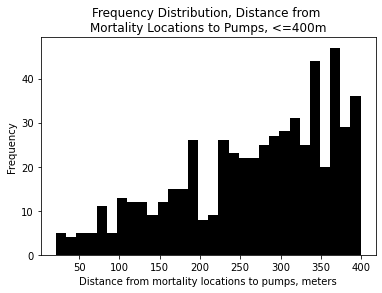

In [38]:
ax = routes400m_df['PD_DISTANCE'].plot.hist(bins=30, color='k')
ax.set_title('Frequency Distribution, Distance from \nMortality Locations to Pumps, <=400m')
ax.set_ylabel('Frequency')
ax.set_xlabel('Distance from mortality locations to pumps, meters')

We can compare `routes_df` and `routes400m_df` for number of records easily using the `print()` statement below.

In [39]:
print('routes_df record count (unfiltered): ', len(routes_df), "\n",\
      'routes400m_df record count (filtered, 400 meters): ', len(routes400m_df))

routes_df record count (unfiltered):  2000 
 routes400m_df record count (filtered, 400 meters):  571


### Under the hood: Visualizing randomly sampled node-to-node distances from computations above

Let's see what's happening under the hood by visualizing some randomly sampled routes between death and pump points. Let's look at 20 samples of death node-pump node pairs. We will use `random.choice` from the python package, `numpy` to select three random death nodes. To keep the pump node constant for each three samples, we will place the random pump code outside the loop. Let's pick the pump node representing the pump at Broadwick Street.

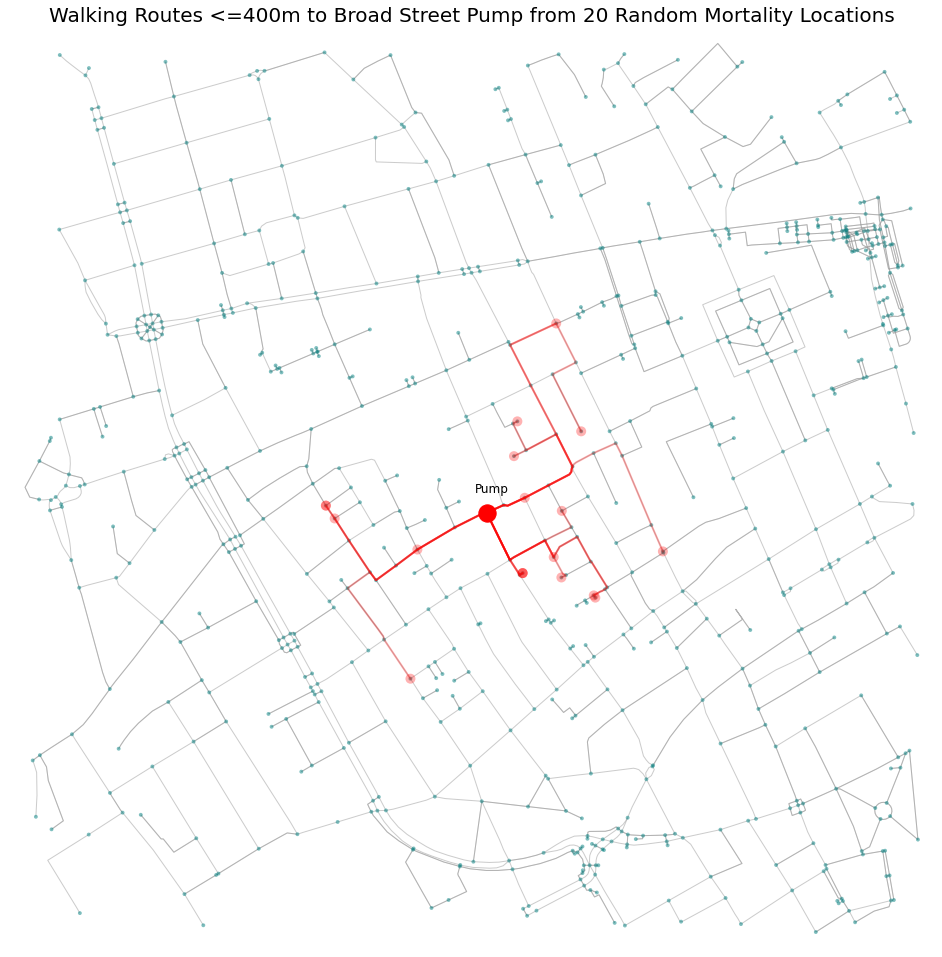

In [40]:
#%%time
import numpy as np
import matplotlib.pyplot as plt

# Pump node at Broadwick Street
pump_node = 25473293

pump_lat = G.nodes[pump_node]['y']
pump_lon = G.nodes[pump_node]['x']
route_list = []
route_color = 'red'
node_color = 'teal'
bgcolor = 'white'
number_of_node_samples = 20

for i in range(number_of_node_samples):
    death_node = np.random.choice(routes_df['DNODE'].unique())
    route = nx.shortest_path(G, death_node, pump_node)
    route_list.append(route)

fig, ax = ox.plot_graph_routes(G, route_list, node_alpha=0.5, edge_alpha=0.5, \
                            bgcolor=bgcolor, node_color=node_color,\
                            edge_linewidth=1,\
                            route_linewidth=2,\
                            route_color=route_color, \
                            route_alpha=0.3, show=False, close=False, \
                            figsize=(17,17))
ax.scatter(pump_lon, pump_lat, c='red', s=300)
ax.text(pump_lon-0.0002, pump_lat+0.0002, 'Pump', fontsize=12)
ax.set_title('Walking Routes <=400m to Broad Street Pump from 20 Random Mortality Locations', pad=1, size=20)

plt.show()

In [41]:
routes400m_df.to_pickle('outputs/routes400m_df.pickle')

You can re-run the code above to see more random pairs.

### Updating `pumps_df` with mean distance values from `d1 + d2 + d3` calculations

Let's store the mean distances between each pump and death locations from `routes_df` to `pumps_df`. 

In [42]:
pumps_df

,FID,LON,LAT,Street,PNODE,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE,DEATHS-MEAN-DISTANCE
0,250,-0.136668,51.513341,Broadwick Street,25473293,-0.136533,51.513391,10.882904,25473293,0.0
1,251,-0.139586,51.513876,Kingly Street,21665926,-0.139462,51.513861,8.746021,21665926,0.0
2,252,-0.139671,51.514906,Ramillies Place,4684520654,-0.139904,51.514855,17.076661,4684520654,0.0
3,253,-0.131630,51.512354,Dean Street,107807,-0.131466,51.512196,20.870820,107807,0.0
4,254,-0.133594,51.512139,Rupert Street,348875443,-0.133606,51.512189,5.593686,348875443,0.0
5,255,-0.135919,51.511542,Bridle Lane,25473300,-0.135762,51.511404,18.794758,25473300,0.0
6,256,-0.133962,51.510019,Regent Street,1663004187,-0.133994,51.510125,11.951782,1663004187,0.0
7,257,-0.138199,51.511295,Warwick Street,25257692,-0.138178,51.511281,2.167033,25257692,0.0


In [43]:
for index, row in pumps_df.iterrows():
    print(row)
    pump_death_distance_400m = routes400m_df.loc[(routes400m_df['PNODE'] == row['NODE'])].PD_DISTANCE
    pump_death_distance = routes_df.loc[(routes_df['PNODE'] == row['NODE'])].PD_DISTANCE
    mean_distance_400m = \
        pump_death_distance_400m.mean()
    mean_distance = \
        pump_death_distance.mean()
    print('DISTANCE LIST 400m:', pump_death_distance_400m.to_list())
    print('=========MEAN DISTANCE 400m:', mean_distance_400m)
    print('DISTANCE LIST:', pump_death_distance.to_list())
    print('=========MEAN DISTANCE:', mean_distance_400m)
    pumps_df.loc[index, 'MEAN-PD-DISTANCE-400M'] = mean_distance_400m
    pumps_df.loc[index, 'MEAN-PD-DISTANCE'] = mean_distance
    #print("Pump "+str(row[0])+":\n ","Node ID: ", row[1]['NODE']\
    #      ,"\n","Mean Distance: ", mean_distance, "meters")


FID                                   250
LON                             -0.136668
LAT                               51.5133
Street                   Broadwick Street
PNODE                            25473293
GLON                            -0.136533
GLAT                              51.5134
NEAREST-NODE-DISTANCE             10.8829
NODE                             25473293
DEATHS-MEAN-DISTANCE                    0
Name: 0, dtype: object
DISTANCE LIST 400m: [149.06777444219236, 154.260409424733, 135.81838748010705, 130.0125929873355, 132.54159895568824, 163.73794891515692, 197.2238998182091, 158.49080431934374, 190.62689901809847, 166.5085852673256, 194.25143217368094, 279.4979350546709, 187.82266601233852, 192.1078844331546, 166.68195000703196, 228.75557353299774, 219.74366270897116, 135.57507029447206, 140.69154100456865, 110.81397238127273, 288.05844486210606, 285.22776609973005, 249.40376564172288, 247.11760316673036, 254.50812736861144, 278.9196875786855, 284.91193958654145, 264.

In [44]:
pumps_df

,FID,LON,LAT,Street,PNODE,GLON,GLAT,NEAREST-NODE-DISTANCE,NODE,DEATHS-MEAN-DISTANCE,MEAN-PD-DISTANCE-400M,MEAN-PD-DISTANCE
0,250,-0.136668,51.513341,Broadwick Street,25473293,-0.136533,51.513391,10.882904,25473293,0.0,213.765428,228.008901
1,251,-0.139586,51.513876,Kingly Street,21665926,-0.139462,51.513861,8.746021,21665926,0.0,262.221634,353.797582
2,252,-0.139671,51.514906,Ramillies Place,4684520654,-0.139904,51.514855,17.076661,4684520654,0.0,338.019838,508.027798
3,253,-0.131630,51.512354,Dean Street,107807,-0.131466,51.512196,20.870820,107807,0.0,NaN,714.090865
4,254,-0.133594,51.512139,Rupert Street,348875443,-0.133606,51.512189,5.593686,348875443,0.0,NaN,843.440891
5,255,-0.135919,51.511542,Bridle Lane,25473300,-0.135762,51.511404,18.794758,25473300,0.0,336.347345,486.120227
6,256,-0.133962,51.510019,Regent Street,1663004187,-0.133994,51.510125,11.951782,1663004187,0.0,NaN,729.342487
7,257,-0.138199,51.511295,Warwick Street,25257692,-0.138178,51.511281,2.167033,25257692,0.0,344.932834,513.518714


> What do the columns `MEAN-PD-DISTANCE` and `MEAN-PD-DISTANCE-400M` mean?

Text(0.5, 0, 'Street Pump')

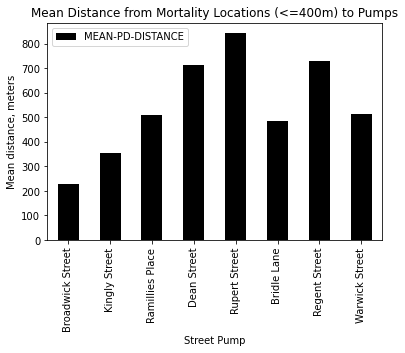

In [45]:
ax = pumps_df.plot.bar(y='MEAN-PD-DISTANCE', x='Street',color='k')
ax.set_title('Mean Distance from Mortality Locations (<=400m) to Pumps')
ax.set_ylabel('Mean distance, meters')
ax.set_xlabel('Street Pump')

Text(0.5, 0, 'Street Pump')

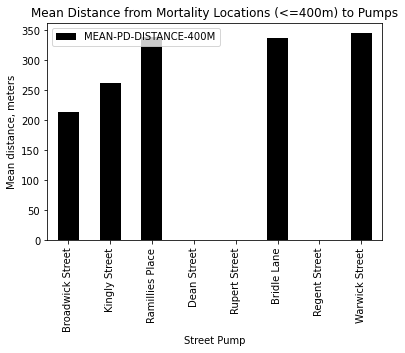

In [46]:
ax = pumps_df.plot.bar(y='MEAN-PD-DISTANCE-400M', x='Street',color='k')
ax.set_title('Mean Distance from Mortality Locations (<=400m) to Pumps')
ax.set_ylabel('Mean distance, meters')
ax.set_xlabel('Street Pump')

1. What do the street pumps having no bars mean? 
2. Which street pump has the shortest mean distance from mortality locations (less than 400 m walk)?

## Step 5: Create `folium` map to show which pumps have mean shortest walkable distance values to most death points

### Recreate Notebook 1 `folium` map and markers for pumps and deaths

In [47]:
mean_center_df = pd.read_pickle('outputs/mean_center_df.pickle')
mean_LON = np.sum(mean_center_df['product_LON'])/np.sum(mean_center_df['DEATHS'])
mean_LAT = np.sum(mean_center_df['product_LAT'])/np.sum(mean_center_df['DEATHS'])
mean_center_df

,FID,DEATHS,LON,LAT,product_LAT,product_LON
0,0,3,-0.137930,51.513418,154.540254,-0.413790
1,1,2,-0.137883,51.513361,103.026722,-0.275766
2,2,1,-0.137853,51.513317,51.513317,-0.137853
3,3,1,-0.137812,51.513262,51.513262,-0.137812
4,4,4,-0.137767,51.513204,206.052816,-0.551068
...,...,...,...,...,...,...
245,245,3,-0.137108,51.514526,154.543578,-0.411324
246,246,2,-0.137065,51.514706,103.029412,-0.274130
247,247,1,-0.138474,51.512311,51.512311,-0.138474
248,248,1,-0.138123,51.511998,51.511998,-0.138123


## Representing the `PD-MEAN-DISTANCE` as circle markers on Folium

In [48]:
import pandas as pd
import folium

# let's import the folium plugins
from folium import plugins

# we already have pumps_df and deaths_df

SOHO_COORDINATES = (51.513578, -0.136722)

map2 = folium.Map(location=SOHO_COORDINATES, zoom_start=16.5, tiles='cartodbpositron')

locationlist = deaths_df[["LAT","LON"]].values.tolist()
radiuslist = deaths_df[["DEATHS"]].values.tolist()

# Iterate through the rows of the cholera deaths data frame 
#    and add each cholera death circle marker to map1
for i in range(0, len(locationlist)):

    # Create a popup for each marker
    # Each marker will show point information and 
    #   number of deaths in that location.    
    popup = folium.Popup('Location: '+'('+str(locationlist[i][0])+\
                         ', '+str(locationlist[i][1])+')'+\
                         '<br/>'+\
                        'Deaths: '+ str(radiuslist[i][0]))
    
    # Add each circle marker with popup representing 
    #   a location with deaths to map1
    folium.CircleMarker(
                    location=locationlist[i], \
                    radius=radiuslist[i], \
                    popup=popup, \
                    color='black', \
                    weight=1, \
                    fill=True, \
                    fill_color='red', \
                    fill_opacity=1).add_to(map2)

# Iterate through the rows of the pumps_df data frame 
#   and add each water pump to map1
for each in pumps_df.iterrows():
    
    # Create a popup for each marker
    # Each marker will show pump location information
    popup = folium.Popup('Location: '+'('+str(each[1]['LAT'])+', '+str(each[1]['LON'])+')')

    # Add each circle marker with popup representing 
    #   a pump location to map1
    pump_marker = folium.RegularPolygonMarker([each[1]['LAT'],each[1]['LON']], \
                    color='black', \
                    weight=1,\
                    fill_opacity=1, \
                    fill_color='blue', \
                    number_of_sides=4, \
                    popup=popup, \
                    radius=10).add_to(map2)

mean_center_df = pd.read_pickle('outputs/mean_center_df.pickle')
mean_LON = np.sum(mean_center_df['product_LON'])/np.sum(mean_center_df['DEATHS'])
mean_LAT = np.sum(mean_center_df['product_LAT'])/np.sum(mean_center_df['DEATHS'])
mean_center_POINT = (mean_LAT, mean_LON)

folium.CircleMarker(
            location=mean_center_POINT, \
            color='black', \
            weight=2, \
            fill_opacity=1, \
            fill_color="yellowgreen", \
            popup=folium.Popup('Mean Center Point: '+ \
                str(mean_center_POINT)), \
            radius=10).add_to(map2)

for row in pumps_df.iterrows():
    # add each water pump mean distance to map1 (divide by 5 to make circle smaller)
    folium.Circle(location=[row[1]['LAT'],row[1]['LON']], \
                  popup='Pump '+str(row[1]['NODE']), \
                  radius=(row[1]['MEAN-PD-DISTANCE'])/5).add_to(map2)


# let's use the "Fullscreen" plugin
# add the button to the top right corner
plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(map2)

map2

Please do not forget to "amplify cognition" by studying tile settings.

## Congratulations!

You have just gained some expertise in:
1. The Cholera Outbreak in 1854 London
2. Use of a few Python packages for data analysis and visualization: `pandas`, `folium`
3. Use of the Open Street Maps - NetworkX package, `osmnx` for street network type analysis
4. Generating value out of information sources (mortality and street network data)

## References

1. Boeing, Geoff. OSMnx: Python for Street Networks. URL: https://geoffboeing.com/2016/11/osmnx-python-street-networks/
2. Networkx. URL: https://networkx.github.io/
3. Shiode S. Revisiting John Snow's map: network-based spatial demarcation of cholera area. International Journal of Geographical Information Science Volume 26, 2012 - Issue 1. URL: https://www.tandfonline.com/doi/abs/10.1080/13658816.2011.577433.

*For case study suggestions for improvement, please contact Herman Tolentino, Jan MacGregor, James Tobias or Zhanar Haimovich.*